# 1 - Introduction

Nama        : Amelia Puspita Sari

Batch       : RMT-30

Objectives  : klasifikasi kualitas dan jenis beras berdasarkan karakteristiknya (bentuk dan warna) dengan menggunakan machine learning

# 2 - Import Libraries

In [2]:
!pip install split-folders

In [3]:
# Import libraries

import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import splitfolders
from PIL import Image

import tensorflow as tf
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading

In [4]:
# Install Kaggle library in Google Collaboratory

## Install Kaggle library
!pip install kaggle

## Make a directory named `.kaggle`
!mkdir ~/.kaggle

## Copy the kaggle.json into this new directory
!cp kaggle.json ~/.kaggle/

## Change permission for this directory :
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download Dataset
# Source dataset : https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data

!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
 89% 195M/219M [00:01<00:00, 201MB/s]
100% 219M/219M [00:01<00:00, 208MB/s]


In [6]:
# Every dataset that downloaded from Kaggle, is in format `.zip`. So, we must unzip it before we can using the dataset.

!unzip ./rice-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [7]:
# List the contents of the main dataset directory
!ls Rice_Image_Dataset

Arborio  Basmati  Ipsala  Jasmine  Karacadag  Rice_Citation_Request.txt


In [8]:
#Dataset Path
data_dir = '/content/Rice_Image_Dataset'
data_dir = pathlib.Path(data_dir)

In [9]:
#Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='Rice_Image_Dataset', seed=20, ratio=(0.8, 0.2))

Copying files: 75000 files [00:17, 4231.43 files/s]


In [10]:
#New dataset path
data_dir = '/content/working/Rice_Image_Dataset'
data_dir = pathlib.Path(data_dir)

In [11]:
#Define path
main_path = '/content/Rice_Image_Dataset'
train_path = os.path.join(main_path, 'train')
val_path = os.path.join(main_path, 'val')

In [12]:
# Check how many data in train_path and test_path
def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(val_path)
print('')

Train Path
Total Data - Basmati : 12000
Total Data - Ipsala : 12000
Total Data - Karacadag : 12000
Total Data - Arborio : 12000
Total Data - Jasmine : 12000

Test Path
Total Data - Basmati : 3000
Total Data - Ipsala : 3000
Total Data - Karacadag : 3000
Total Data - Arborio : 3000
Total Data - Jasmine : 3000



# 4 - EDA

-----

Background

-----

Dalam dunia bisnis kuliner, kualitas bahan baku memainkan peran penting dalam menentukan rasa, nilai gizi, dan kepercayaan konsumen terhadap produk makanan yang dihasilkan. Salah satu bahan baku yang paling umum dan penting dalam berbagai masakan adalah beras. Beras bukan hanya bahan makanan pokok di banyak negara, tetapi juga bahan utama dalam berbagai hidangan kuliner internasional.

Untuk restoran dan bisnis kuliner Timur Tengah, menggunakan jenis beras yang tepat untuk setiap hidangan adalah hal yang paling krusial. Menggunakan dataset dari kaggle dapat dijadikan acuan untuk membantu memilih jenis dan kualitas beras yang akan digunakan. Dataset ini menyediakan gambar dari berbagai varietas padi, seperti Arborio, Basmati, Ipsala, Jasmine, dan Karacadag.

Dengan memanfaatkan dataset ini, bisnis kuliner dapat mengintegrasikan teknologi canggih untuk meningkatkan kontrol kualitas, efisiensi operasional, dan inovasi produk. Hal ini tidak hanya membantu dalam menjaga standar tinggi dan kepuasan pelanggan, tetapi juga memberikan keunggulan kompetitif dalam industri kuliner yang semakin berkembang dan dinamis.

In [13]:
def plot_images(path):
    labels = os.listdir(path)
    for label in labels:
        folder_path = os.path.join(path, label)
        fig = plt.figure(figsize=(20, 4))  # Adjusted the height for a single row of images
        columns = 5
        rows = 1
        print('Class : ', label)
        images = os.listdir(folder_path)

        # Ensure there are at least 5 images
        if len(images) < columns:
            print(f"Warning: Less than {columns} images in folder '{label}'")
            continue

        for index in range(columns):  # Use 'columns' instead of 'columns*rows'
            fig.add_subplot(rows, columns, index + 1)
            image = plt.imread(os.path.join(folder_path, images[index]))
            plt.imshow(image)
            plt.axis("off")

        plt.show()

Class :  Basmati


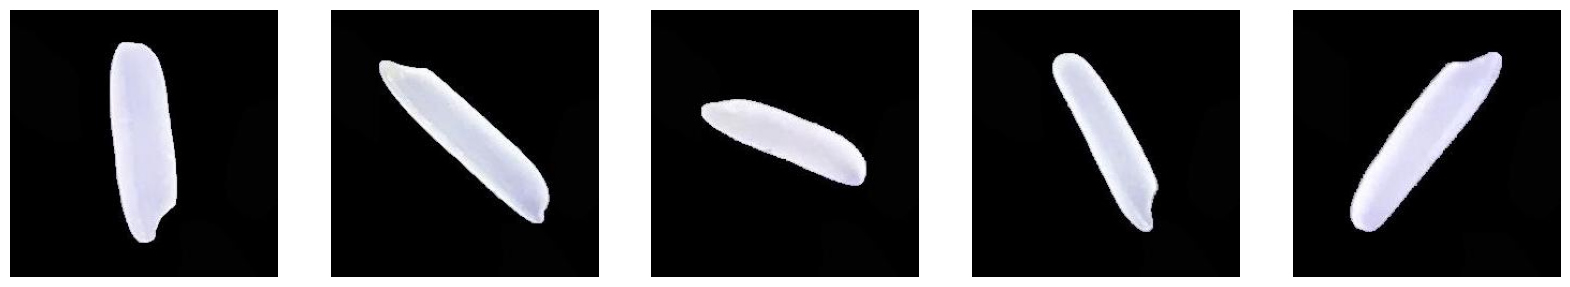

Class :  Ipsala


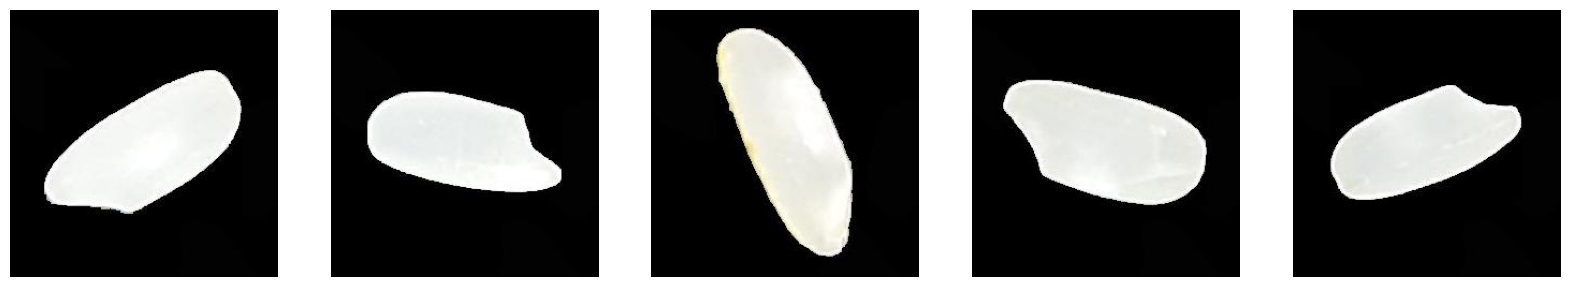

Class :  Karacadag


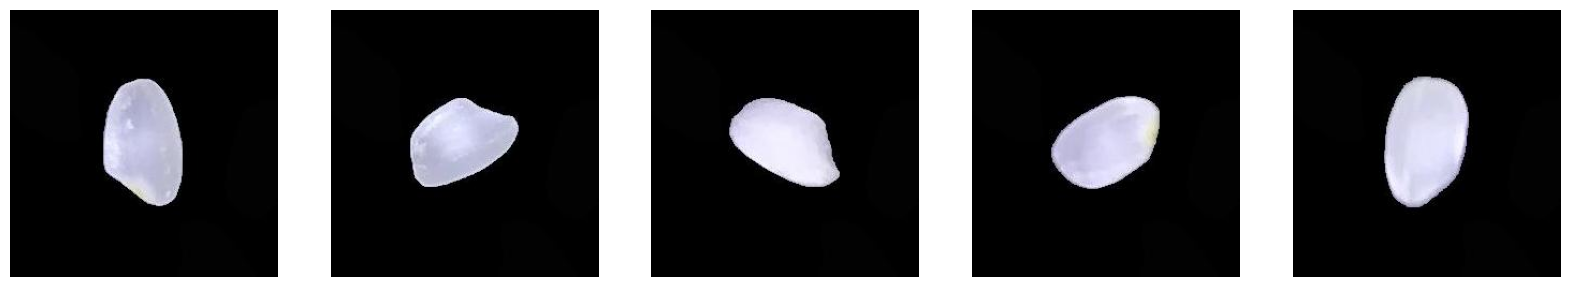

Class :  Arborio


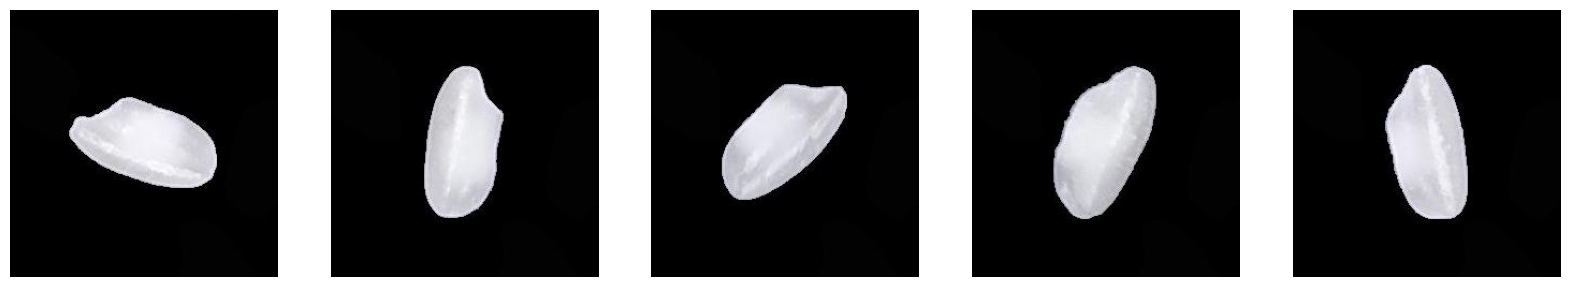

Class :  Jasmine


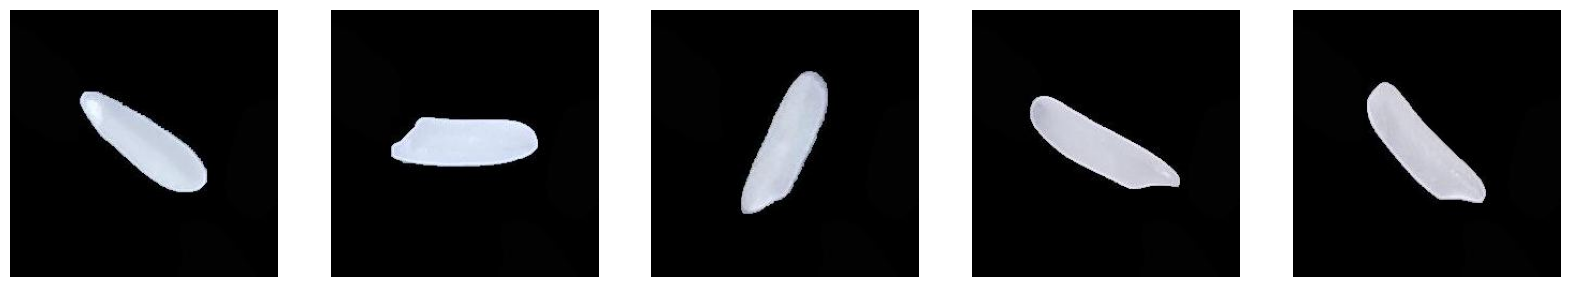

In [14]:
# Visualization of train_path

plot_images(train_path)

Class :  Basmati


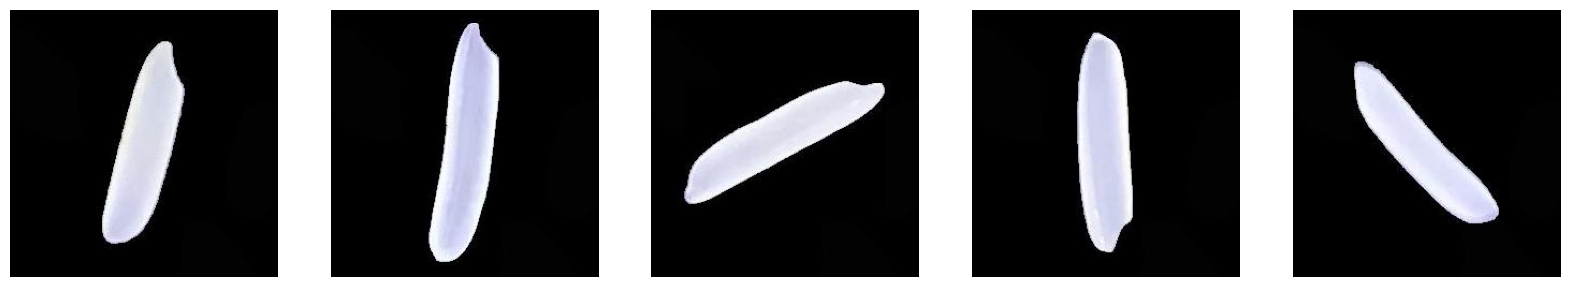

Class :  Ipsala


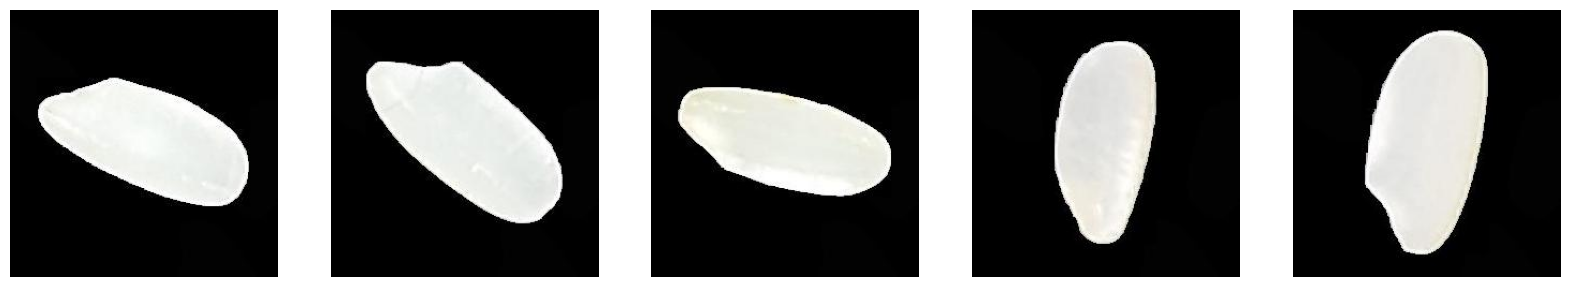

Class :  Karacadag


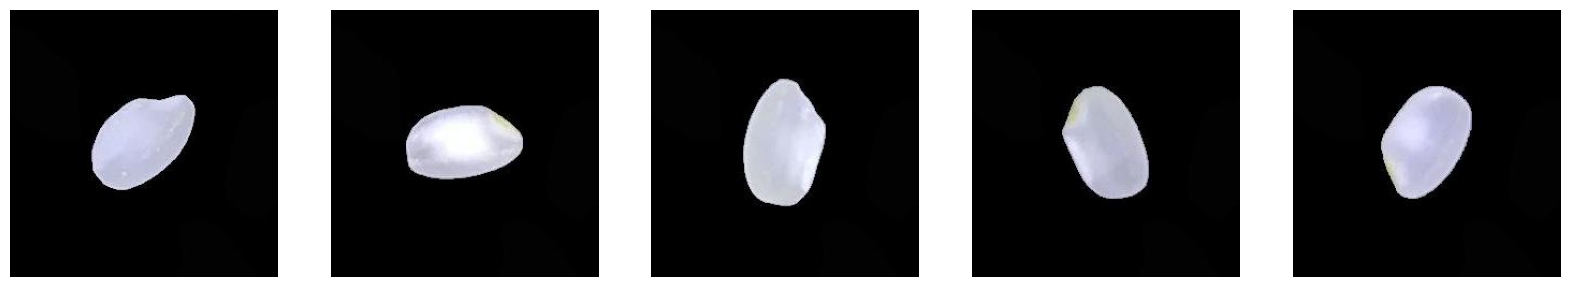

Class :  Arborio


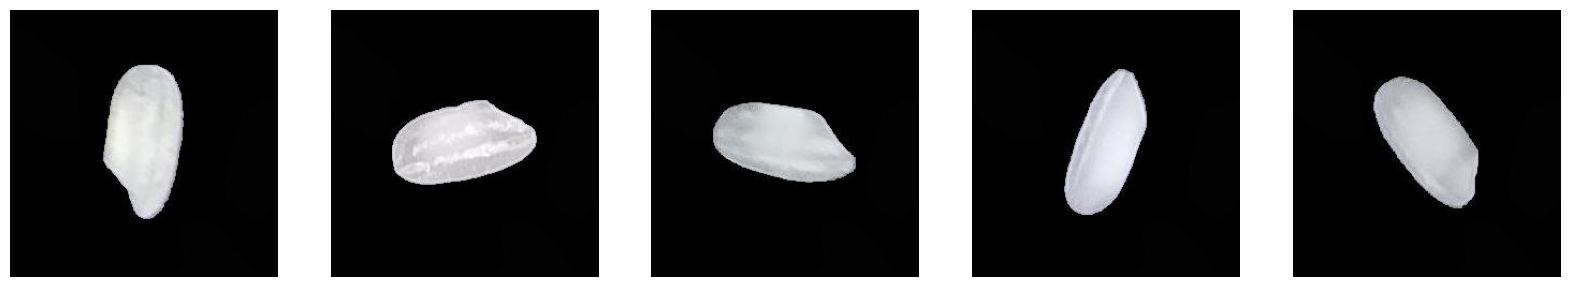

Class :  Jasmine


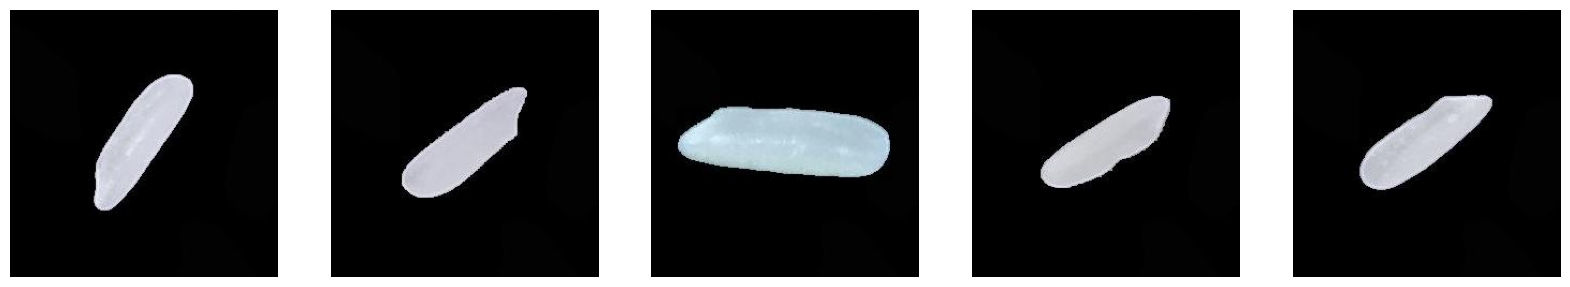

In [15]:
# Visualization of `test_path`

plot_images(val_path)

In [16]:
# Function to count images in each class
def count_images(path):
    class_counts = {}
    for class_dir in os.listdir(path):
        class_path = os.path.join(path, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

# Count images in train and val directories
train_counts = count_images(train_path)
val_counts = count_images(val_path)

Class Distribution in Training Set:


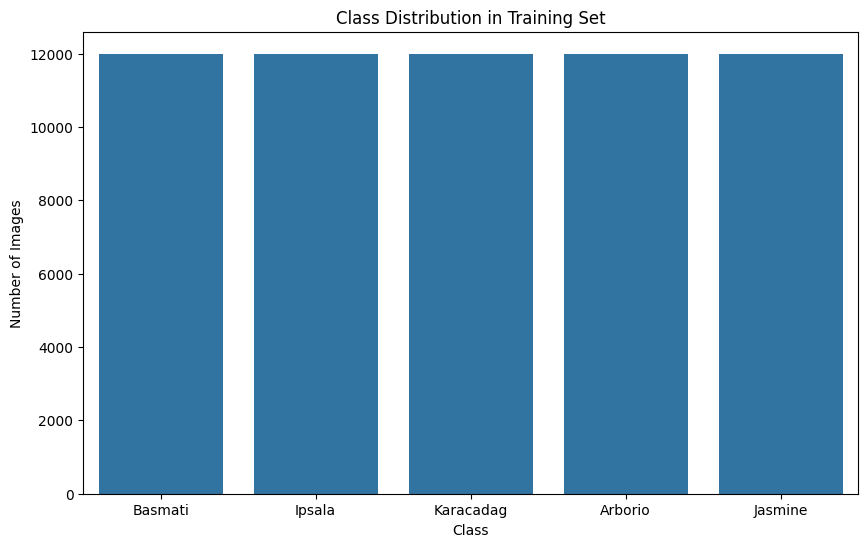

Class Distribution in Validation Set:


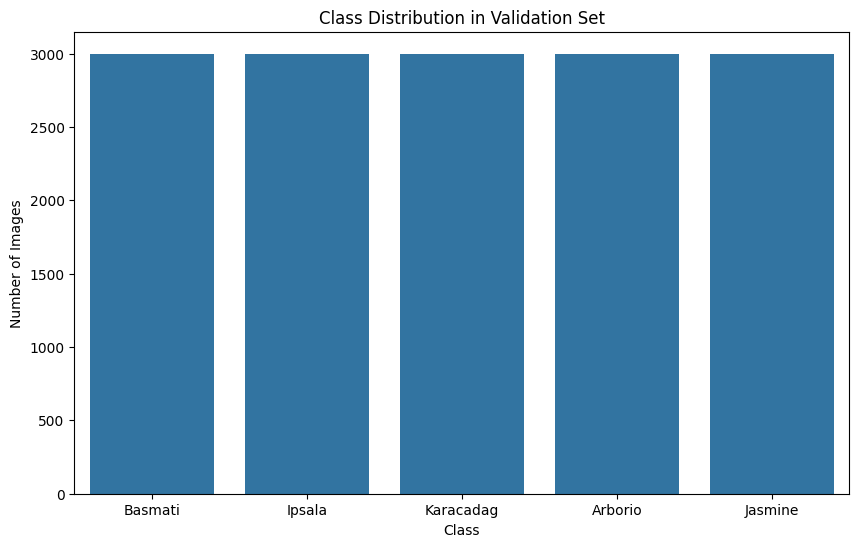

In [17]:
# Display class distribution
def plot_class_distribution(counts, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

print('Class Distribution in Training Set:')
plot_class_distribution(train_counts, 'Class Distribution in Training Set')

print('Class Distribution in Validation Set:')
plot_class_distribution(val_counts, 'Class Distribution in Validation Set')

In [18]:
# Check image size statistics
def image_size_statistics(path):
    widths, heights = [], []
    for class_dir in os.listdir(path):
        class_path = os.path.join(path, class_dir)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path)
                width, height = img.size
                widths.append(width)
                heights.append(height)
    return widths, heights

train_widths, train_heights = image_size_statistics(train_path)
val_widths, val_heights = image_size_statistics(val_path)

Image Size Distribution in Training Set:


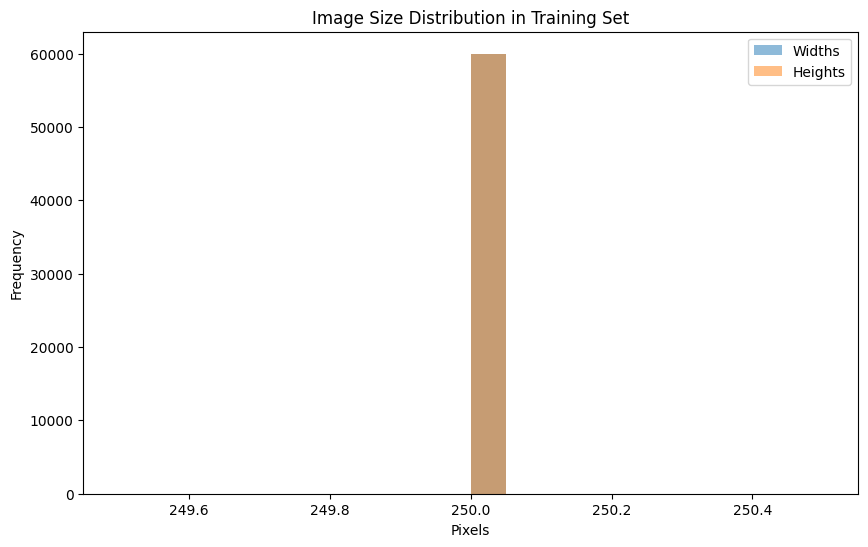

Image Size Distribution in Validation Set:


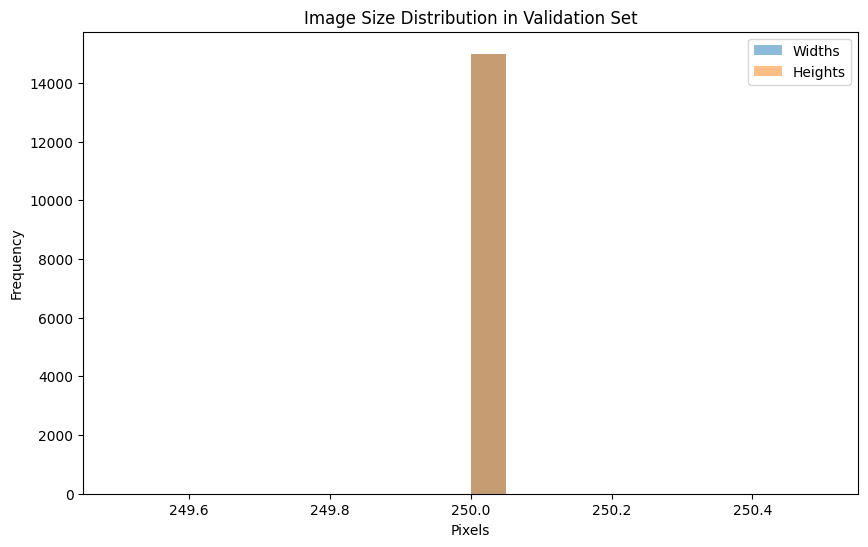

In [19]:
# Plot image size distribution
def plot_image_size_distribution(widths, heights, title):
    plt.figure(figsize=(10, 6))
    plt.hist(widths, bins=20, alpha=0.5, label='Widths')
    plt.hist(heights, bins=20, alpha=0.5, label='Heights')
    plt.title(title)
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

print('Image Size Distribution in Training Set:')
plot_image_size_distribution(train_widths, train_heights, 'Image Size Distribution in Training Set')

print('Image Size Distribution in Validation Set:')
plot_image_size_distribution(val_widths, val_heights, 'Image Size Distribution in Validation Set')

# 5 - FE

In [41]:
# Define hyperparameters

img_height= 250
img_width= 250
batch_size= 200

In [21]:
# Create batch generator for train-set, val-set, and test-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=2)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(val_path,
                                            target_size=(img_height,img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=2)

Found 36000 images belonging to 5 classes.
Found 24000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [22]:
# Show labels

train_set.class_indices

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

# 6 - ANN Training

## 6.2 - Model Definition

In [23]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [24]:
# Create Sequential API model

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 29, 29, 128)       0

- model capacity:
model memiliki 55 juta parameter, yang menunjukkan bahwa model ini mampu menangani dataset gambar yang kompleks dan besar

- conv layer:
ada 3 conv layer dengan jumlah filter yang meningkat dari 32 ke 64, kemudian ke 128. untuk membantu model menangkap fitur dari gambar dengan berbagai skala dan kompleksitas

- pooling:
setiap conv layer diikuti dengan lapisan pooling, yang membantu dalam pengurangan dimensi data dan mengurangi overfitting dengan mengambil fitur yang paling penting

- flatten dan dense layer:
flatten mengubah output 3D dari conv layer menjadi 1D sebelum memasuki dense. dense layer dengan 512 unit memberikan kapasitas untuk melakukan klasifikasi berdasarkan fitur yang diekstraksi oleh lapisan konvolusi.

- dropout:
dropout digunakan untuk mengurangi overfitting dengan mematikan sejumlah neuron secara acak selama training, meningkatkan kemampuan generalisasi model

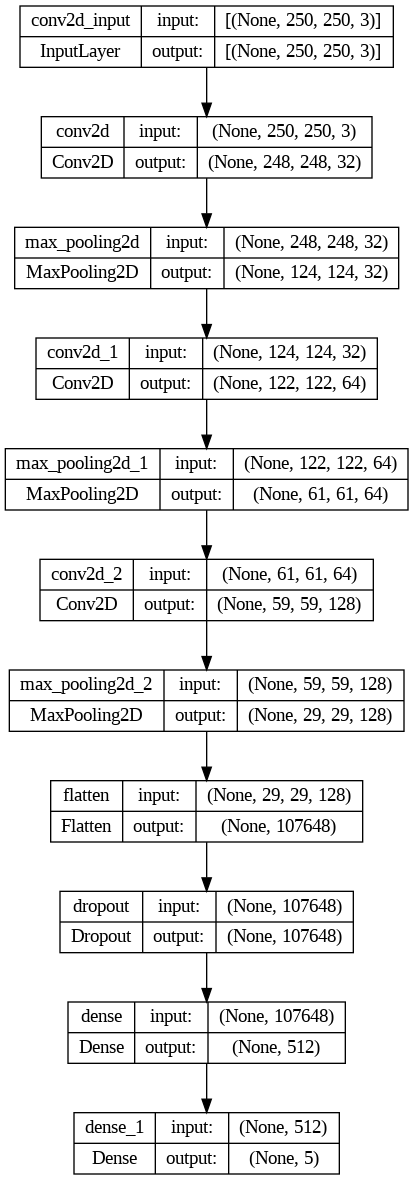

In [25]:
# Plot layers

tf.keras.utils.plot_model(model, show_shapes=True)

## 6.3 - Model Training

In [26]:
# Train the model

%%time
history = model.fit(train_set, epochs=20, validation_data=val_set, batch_size=batch_size)

Epoch 1/20
180/180 [==============================] - 168s 843ms/step - loss: 0.1516 - accuracy: 0.9556 - val_loss: 1.4957 - val_accuracy: 0.8755
Epoch 2/20
180/180 [==============================] - 175s 972ms/step - loss: 0.0568 - accuracy: 0.9803 - val_loss: 1.4709 - val_accuracy: 0.8824
Epoch 3/20
180/180 [==============================] - 165s 919ms/step - loss: 0.0421 - accuracy: 0.9854 - val_loss: 1.6860 - val_accuracy: 0.8735
Epoch 4/20
180/180 [==============================] - 149s 826ms/step - loss: 0.0282 - accuracy: 0.9904 - val_loss: 1.7760 - val_accuracy: 0.8863
Epoch 5/20
180/180 [==============================] - 148s 823ms/step - loss: 0.0201 - accuracy: 0.9933 - val_loss: 1.6424 - val_accuracy: 0.8831
Epoch 6/20
180/180 [==============================] - 148s 821ms/step - loss: 0.0183 - accuracy: 0.9937 - val_loss: 1.9109 - val_accuracy: 0.8865
Epoch 7/20
180/180 [==============================] - 149s 827ms/step - loss: 0.0152 - accuracy: 0.9951 - val_loss: 1.4062 -

model mampu mencapai akurasi training yang sangat tinggi hingga nyaris sempurna namun menunjukkan tanda-tanda overfitting karena peningkatan loss pada validasi. tetapi, akurasi validasi tetap stabil di sekitar 88%. selanjutnya akan augmentasi data untuk mengurangi overfitting dan meningkatkan generalisasi model.

## 6.4 - Model Evaluation

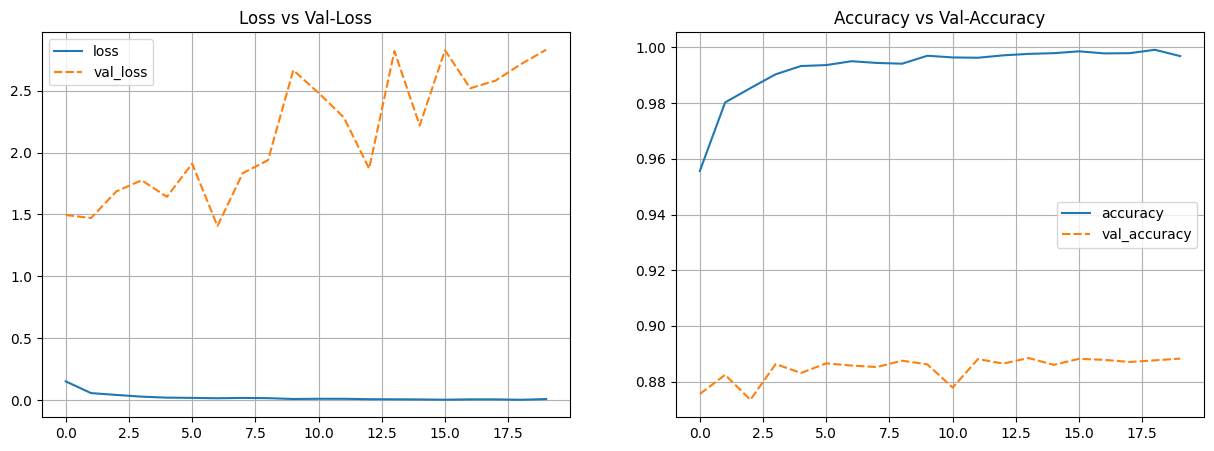

In [27]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

model ini sepertinya overfitting karena “val_loss” fluktuatif dan “val_accuracy” tidak meningkat secara signifikan

In [28]:
# Check the performance of test-set

## Get the probability
y_pred_prob = model.predict_generator(test_set)

## Get class with maximum probability
y_pred_class = np.argmax(y_pred_prob, axis=-1)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

              precision    recall  f1-score   support

     Arborio       1.00      0.99      0.99      3000
     Basmati       0.82      0.99      0.90      3000
      Ipsala       0.99      1.00      1.00      3000
     Jasmine       0.98      0.78      0.87      3000
   Karacadag       0.99      1.00      1.00      3000

    accuracy                           0.95     15000
   macro avg       0.96      0.95      0.95     15000
weighted avg       0.96      0.95      0.95     15000



- performa model sangat baik dalam mengklasifikasikan kelas Arborio, Ipsala, dan Karacadag, dengan presisi, recall, dan F1-score yang sangat tinggi
- namun untuk kelas Basmati dan Jasmine, model masih bagus dalam mengklasifikasikan Basmati, tetapi sedikit kurang bagus dalam mengklasifikasikan Jasmine, terutama dalam metric recall

# 7 - ANN improvement

## 7.2 - Model Definition

In [29]:
# Clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [36]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator for validation set (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

train_set_aug = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=20,
    class_mode='categorical'  # Use 'categorical' for categorical_crossentropy
)

val_set_aug = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=20,
    class_mode='categorical'  # Use 'categorical' for categorical_crossentropy
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [37]:
# Create Sequential API model

model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width,3)))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dense(5, activation='softmax'))

# Compile
model_aug.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 124, 124, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 29, 29, 128)      

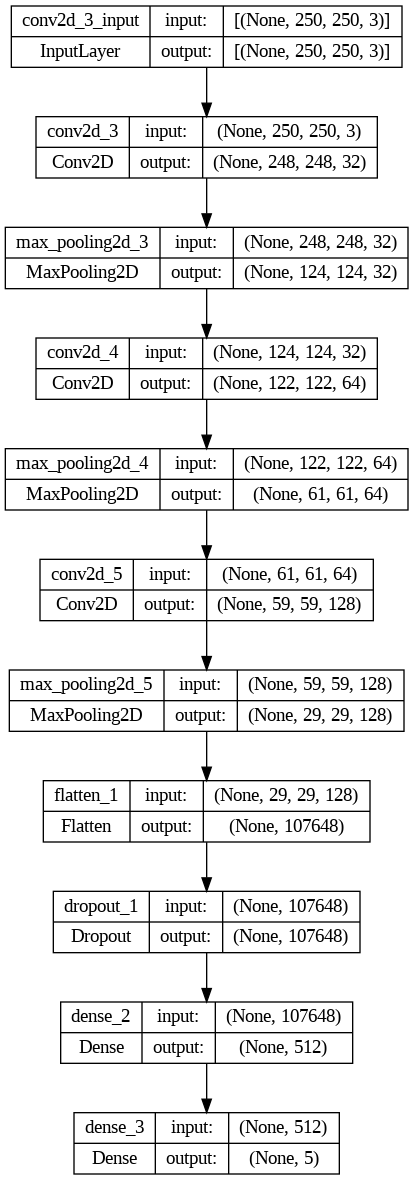

In [38]:
# Plot layers

tf.keras.utils.plot_model(model_aug, show_shapes=True)

## 7.3 - Model Training

In [44]:
# Train the model

%%time
history_aug = model_aug.fit(train_set_aug, epochs=5, validation_data=val_set_aug, batch_size=batch_size)

Epoch 1/5
3000/3000 [==============================] - 1041s 347ms/step - loss: 0.2076 - accuracy: 0.9251 - val_loss: 2.1762 - val_accuracy: 0.7039
Epoch 2/5
3000/3000 [==============================] - 986s 329ms/step - loss: 0.1136 - accuracy: 0.9601 - val_loss: 0.1954 - val_accuracy: 0.9437
Epoch 3/5
3000/3000 [==============================] - 995s 332ms/step - loss: 0.0886 - accuracy: 0.9689 - val_loss: 0.4790 - val_accuracy: 0.8802
Epoch 4/5
3000/3000 [==============================] - 1001s 334ms/step - loss: 0.1061 - accuracy: 0.9630 - val_loss: 1.5375 - val_accuracy: 0.7696
Epoch 5/5
3000/3000 [==============================] - 989s 330ms/step - loss: 0.0890 - accuracy: 0.9700 - val_loss: 1.9894 - val_accuracy: 0.7483
CPU times: user 1h 33min 25s, sys: 1min 23s, total: 1h 34min 48s
Wall time: 1h 24min 13s


model berhasil mencapai akurasi yang tinggi pada train setelah menggunakan model augmented, tetapi masih ada overfitting yang jelas terhadap validasi

## 7.4 - Model Evaluation

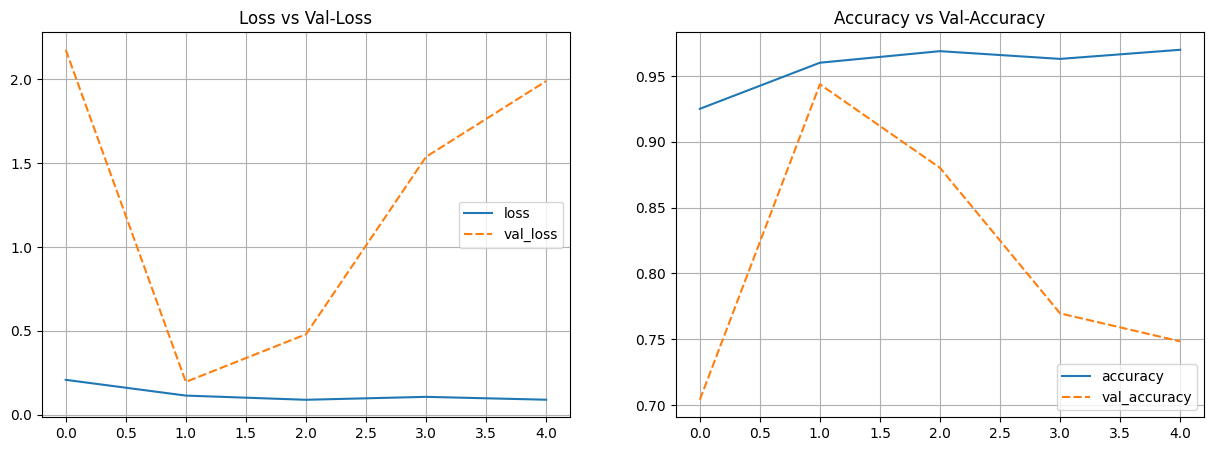

In [45]:
# Plot training results

history_aug_df = pd.DataFrame(history_aug.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

grafik ini juga menunjukkan fluktuasi pada validasi

In [46]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict_generator(test_set)

## Get class with maximum probability
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=-1)

## Display Classification Report
print(classification_report(test_set.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

              precision    recall  f1-score   support

     Arborio       0.77      0.20      0.32      3000
     Basmati       0.99      0.91      0.95      3000
      Ipsala       0.47      1.00      0.64      3000
     Jasmine       0.92      0.74      0.82      3000
   Karacadag       1.00      0.89      0.94      3000

    accuracy                           0.75     15000
   macro avg       0.83      0.75      0.73     15000
weighted avg       0.83      0.75      0.73     15000



- model memiliki performa yang bervariasi tergantung pada kelasnya

- performa terbaik diperoleh untuk kelas Basmati, Jasmine, dan Karacadag, dengan presisi, recall, dan F1-score yang baik.

- namun kelas Arborio dan Ipsala, kinerja model kurang baik, terutama dalam hal recall.

# 8 - Model Saving

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
# Define the path where you want to save the model in Google Drive
model_save_path = '/content/drive/MyDrive/rice_classification_model.h5'


In [50]:
# Save the model to the defined path
model_aug.save(model_save_path)

# Alternatively, save the model in the TensorFlow SavedModel format
model_save_dir = '/content/drive/MyDrive/rice_classification_model'
model_aug.save(model_save_dir)

# 9 - Model Inference

dilakukan di notebook berbeda

# 10 - Kesimpulan

- sesuai arahan, epochs yang digunakan seharusnya 20. namun dikarenakan limitasi environment yang digunakan dalam mengerjakan dataset ini, untuk training model dengan augmentation hanya dibatasi menjadi epochs = 5. Itupun cukup memakan waktu yang lama 

- akurasi model jauh lebih baik saat sebelum augmentation walaupun keduanya masih overfit. Tetapi rata-rata akurasi tiap kelasnya cukup tinggi dan tidak ada yang terlalu rendah seperti saat model di augmentasi